<a href="https://colab.research.google.com/github/auto-d/vision-mapping/blob/main/viz_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision Mapping

!TODO
- test ViT implementation in colab
    - dinov3 m
- select image dataset and explanation
- find gradcam library (torchcam?) - ensure compatibility with VIT
- load and make predictions with pretrained model
- apply gradcam to ViT
- update link
- profit

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](update_me)

## GradCAM

In [2]:
!pip install torchcam

In [3]:
%matplotlib inline
# All imports
import matplotlib.pyplot as plt
import torch
from torch.nn.functional import softmax, interpolate
from torchvision.io.image import read_image
from torchvision.models import resnet18
from torchvision.transforms.functional import normalize, resize, to_pil_image

from torchcam.methods import SmoothGradCAMpp, LayerCAM
from torchcam.utils import overlay_mask

In [4]:
# Download an image
!wget https://www.woopets.fr/assets/races/000/066/big-portrait/border-collie.jpg
# Set this to your image path if you wish to run it on your own data
img_path = "border-collie.jpg"

--2025-10-05 14:51:40--  https://www.woopets.fr/assets/races/000/066/big-portrait/border-collie.jpg
Resolving www.woopets.fr (www.woopets.fr)... 172.67.73.8, 104.26.12.50, 104.26.13.50, ...
Connecting to www.woopets.fr (www.woopets.fr)|172.67.73.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39710 (39K) [image/jpeg]
Saving to: ‘border-collie.jpg’

border-collie.jpg   100%[===================>]  38.78K  --.-KB/s    in 0s      

2025-10-05 14:51:41 (91.9 MB/s) - ‘border-collie.jpg’ saved [39710/39710]



In [5]:
# Instantiate your model here
model = resnet18(pretrained=True).eval()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 115MB/s]


In [6]:
cam_extractor = SmoothGradCAMpp(model)
# Get your input
img = read_image(img_path)
# Preprocess it for your chosen model
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
cams = cam_extractor(out.squeeze(0).argmax().item(), out)

In [7]:
# Notice that there is one CAM per target layer (here only 1)
for cam in cams:
  print(cam.shape)

torch.Size([1, 7, 7])


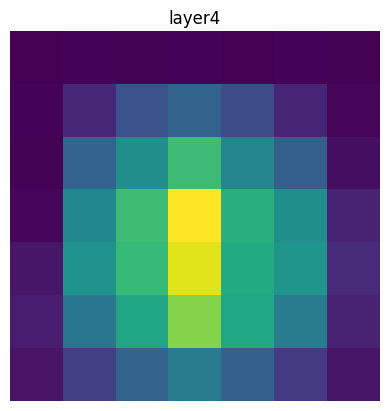

In [8]:
# The raw CAM
for name, cam in zip(cam_extractor.target_names, cams):
  plt.imshow(cam.squeeze(0).numpy()); plt.axis('off'); plt.title(name); plt.show()

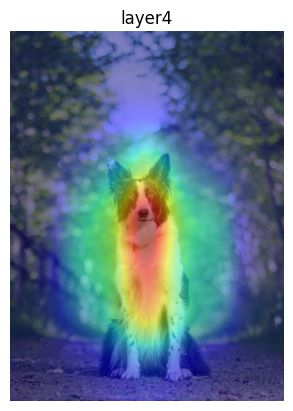

In [9]:
# Overlayed on the image
for name, cam in zip(cam_extractor.target_names, cams):
  result = overlay_mask(to_pil_image(img), to_pil_image(cam.squeeze(0), mode='F'), alpha=0.5)
  plt.imshow(result); plt.axis('off'); plt.title(name); plt.show()

## DINOv3

In [3]:
!git clone https://github.com/facebookresearch/dinov3.git

Cloning into 'dinov3'...
remote: Enumerating objects: 409, done.
remote: Counting objects: 100% (198/198), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 409 (delta 124), reused 62 (delta 62), pack-reused 211 (from 2)
Receiving objects: 100% (409/409), 9.83 MiB | 16.74 MiB/s, done.
Resolving deltas: 100% (156/156), done.


In [8]:
!pip install -r dinov3/requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 35.7 MB/s eta 0:00:00


In [14]:
import sys
sys.path.append("dinov3")

In [15]:
from dinov3.hub.dinotxt import dinov3_vitl16_dinotxt_tet1280d20h24l

In [16]:
dinov3_vitl16_file = "dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth"

In [17]:
!wget "https://dinov3.llamameta.net/dinov3_vitl16/dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoidjZ1dnF1N2xtOGxrMHIzMXZnd2t2cmZmIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NTk4Mzc2NDd9fX1dfQ__&Signature=qZAn6kO25XPYNsMCVEmHSt9hkADOm80vRJdqLKA09eNBcEXicYGkbHaYgmD2SPIzvelcSV4PpIb9OZg1WNq8QCgykTu1LiHJq3sdUGWEpWNYHYRYkKyl6fyACNOtVaQK%7EYniuFvWECB4CVOJrT0FT%7Eee5i6bl4VaQPkwZcnYyranryOiKxm0bMe8y9ncGJHXa82lyJcdidOTk6vE7JRIwbgnMIpAZw6zHjmphirSD3nAbfvItKZfX8dVuecWmj3St%7EhQFLWRCkencU176yuTsKRIUgXjC13AQ-jaT1-M0nG2eaIUw5vDFaIz-5nXeyPpWYoOkkYMYThSySIWn5JWdA__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=1826303031621931" -O $dinov3_vitl16_file

--2025-10-05 15:03:34--  https://dinov3.llamameta.net/dinov3_vitl16/dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoidjZ1dnF1N2xtOGxrMHIzMXZnd2t2cmZmIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NTk4Mzc2NDd9fX1dfQ__&Signature=qZAn6kO25XPYNsMCVEmHSt9hkADOm80vRJdqLKA09eNBcEXicYGkbHaYgmD2SPIzvelcSV4PpIb9OZg1WNq8QCgykTu1LiHJq3sdUGWEpWNYHYRYkKyl6fyACNOtVaQK%7EYniuFvWECB4CVOJrT0FT%7Eee5i6bl4VaQPkwZcnYyranryOiKxm0bMe8y9ncGJHXa82lyJcdidOTk6vE7JRIwbgnMIpAZw6zHjmphirSD3nAbfvItKZfX8dVuecWmj3St%7EhQFLWRCkencU176yuTsKRIUgXjC13AQ-jaT1-M0nG2eaIUw5vDFaIz-5nXeyPpWYoOkkYMYThSySIWn5JWdA__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=1826303031621931
Resolving dinov3.llamameta.net (dinov3.llamameta.net)... 18.164.174.41, 18.164.174.21, 18.164.174.56, ...
Connecting to dinov3.llamameta.net (dinov3.llamameta.net)|18.164.174.41|:443... connected.
HTTP request sent, awaiting response.

In [18]:
import os
import torch

In [19]:
def check_acceleration():
    """
    Check for acceleration/GPU and return an indicator
    """
    device = None
    gpus = torch.cuda.is_available()
    if gpus:
        device = "cuda"
        print("GPU acceleration appears to be available!")
        for device in range(1, torch.cuda.device_count()):
            print(f"Found {torch.cuda.get_device_name(device)}")
    else:
        device = "cpu"
        print("GPU resources not found, defaulting to CPU.")

    return device

In [20]:
device = check_acceleration()

GPU resources not found, defaulting to CPU.


In [21]:
def inspect_model_file(path, device):
    """
    Inspect a torch .pth
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"Model file {path} doesn't exist!")
    kwargs = {} if device == "cuda" else { "map_location": torch.device('cpu') }
    data = torch.load(path, **kwargs)
    print(type(data))
    for k, v in data.items():
        print(k, v.shape)

In [22]:
REPO_DIR = "./dinov3"
dinov3_vitl16 = torch.hub.load(REPO_DIR, 'dinov3_vitl16', source='local', weights=dinov3_vitl16_file)

In [23]:
inspect_model_file(dinov3_vitl16_file, device)


<class 'collections.OrderedDict'>
cls_token torch.Size([1, 1, 1024])
storage_tokens torch.Size([1, 4, 1024])
mask_token torch.Size([1, 1024])
patch_embed.proj.weight torch.Size([1024, 3, 16, 16])
patch_embed.proj.bias torch.Size([1024])
rope_embed.periods torch.Size([16])
blocks.0.norm1.weight torch.Size([1024])
blocks.0.norm1.bias torch.Size([1024])
blocks.0.attn.qkv.weight torch.Size([3072, 1024])
blocks.0.attn.qkv.bias torch.Size([3072])
blocks.0.attn.qkv.bias_mask torch.Size([3072])
blocks.0.attn.proj.weight torch.Size([1024, 1024])
blocks.0.attn.proj.bias torch.Size([1024])
blocks.0.ls1.gamma torch.Size([1024])
blocks.0.norm2.weight torch.Size([1024])
blocks.0.norm2.bias torch.Size([1024])
blocks.0.mlp.fc1.weight torch.Size([4096, 1024])
blocks.0.mlp.fc1.bias torch.Size([4096])
blocks.0.mlp.fc2.weight torch.Size([1024, 4096])
blocks.0.mlp.fc2.bias torch.Size([1024])
blocks.0.ls2.gamma torch.Size([1024])
blocks.1.norm1.weight torch.Size([1024])
blocks.1.norm1.bias torch.Size([1024]

In [32]:
model.layer4[1]

BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [24]:
type(dinov3_vitl16)

dinov3.models.vision_transformer.DinoVisionTransformer

In [11]:
model, tokenizer = dinov3_vitl16_dinotxt_tet1280d20h24l()

Downloading: "https://dl.fbaipublicfiles.com/dinov3/dinov3_vitl16/dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth" to /root/.cache/torch/hub/checkpoints/dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth


HTTPError: HTTP Error 403: Forbidden